In [1]:
import numpy as np
from scipy import sparse
import sklearn

In [2]:
params = {}
params["lambda"] = 0.1
params["alpha"] = 0.1

params["gamma"] = 0.1*params["lambda"]


### Generating Dense Dataset

In [157]:
n = 1000;
p = 5000;
sparsity_level = 0.1;
block_size = 100


sparse_ = np.random.uniform(size=p) > sparsity_level
Beta_true = np.random.normal(size=(p))*sparse_
Beta_true = sparse.csc_matrix(Beta_true).T


X = np.random.random((n, p))
p_real = sum(sparse_)
print("Only ", p_real, "non zeros beta")
#X_real = np.random.random((n, p_real))
#X = sparse.csc_matrix((n, p))
#j = 0
#for j_real in range(p_real):
#    print(j_real)
#    while not sparse_[j]:
#    j+=1
#    X[:, j] = X_real[:, j_real:j_real+1]
#
print("X computed", X.shape, Beta_true.shape)


y = np.random.normal((X @ Beta_true), 0.01)
print("y computed")
A = 1/np.sqrt(n)*X
c = -1/n*X.T @ y

Only  4495 non zeros beta
X computed (1000, 5000) (5000, 1)
y computed


In [158]:
import matplotlib.pyplot as plt

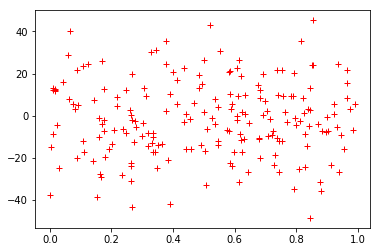

In [159]:
plt.plot(X[:200, 0], y[:200], "r+");


## Optimization

In [160]:
def penalty(z):
    return params["lambda"]*((1-params["alpha"])/2*np.linalg.norm(z, 1) + params["alpha"]*np.linalg.norm(z, 2))

In [161]:
#print(c.shape)
def lagrangian(beta, xi, z, gamma=params["gamma"]):
    #print(beta.sign, beta.curvature)
    
    first = 1/2*np.linalg.norm(A @ beta, 2) 
    third = 1/2*gamma*np.linalg.norm(beta - z, 2) ## diminue si beta = z
    second = (c - xi).T @ beta ## diminue si beta augmente
    #print(first, second, third, fourth)
    #return first.squeeze() + second.squeeze() + third.squeeze() + fourth.squeeze() + penalty(z).squeeze()
    return first + second + third + penalty(z)


In [162]:
def soft_thres(a, b):
    return -((np.abs(b) < a)*((a>0)*(a-b)+(a<=0)*(a+b)))

In [163]:
def optimal_z(beta, xi, 
              alpha=params["alpha"], 
              lambd=params["lambda"], 
              gamma=params["gamma"]):
    return soft_thres(xi-gamma*beta, lambd*alpha)/((1-alpha)*lambd+gamma)

In [164]:
B = A.T @ A + params["gamma"]*np.eye(p)

In [165]:
## Algo



def one_cycle_racmbadmm(p, beta, xi, z):
    num_blocks = p // block_size
    # Split in blocks
    permutation = list(range(p))
    np.random.shuffle(permutation)
    
    # Optimize beta
    for i in range(num_blocks):
        indexes = permutation[(i*block_size):((i+1)*block_size)]
        remaining_indexes = [i for i in range(p) if i not in indexes]
        #print("indexes", indexes)
        B1 = B[np.ix_(indexes, indexes)]
        B2 = B[np.ix_(indexes, remaining_indexes)]

        # Closed form optimum
        betasub_opt = - np.linalg.inv(B1)@(B2 @ beta[remaining_indexes] + (c-xi-params["gamma"]*z)[indexes])
        
        beta[indexes] = betasub_opt

    # Optimal z
    z = optimal_z(beta, xi)
    # Optimize xi
    xi = xi - params["gamma"]*(beta - z)
    
    return beta, xi, z

In [166]:
#lagrangian(Beta_true, 0, Beta_true)

In [167]:
beta0 = np.zeros((p, 1))
z0 = np.zeros((p, 1))
xi0 = np.zeros((p, 1))

In [168]:
lag = []
beta_error = []
for k in range(10): 
    beta0, xi0, z0 = one_cycle_racmbadmm(p, beta0, xi0, z0)
    beta_error.append(np.linalg.norm(Beta_true - beta0, 2))
    lag.append(lagrangian(beta0, xi0, z0))
    #print()

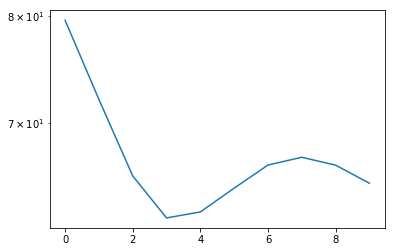

In [169]:
plt.plot(beta_error)
plt.yscale("log")
#plt.xscale("log")

In [174]:
print("Final error is", beta_error[-1])

Final error is 64.93115294089777


## Scikit learn



In [175]:
from sklearn.linear_model import ElasticNet
sklearn_model = ElasticNet(alpha=params["lambda"], l1_ratio=params["alpha"])

In [176]:
reg_ = sklearn_model.fit(X, y)

In [177]:
reg_.coef_.shape
Beta_true[:, 0]

<5000x1 sparse matrix of type '<class 'numpy.float64'>'
	with 4495 stored elements in Compressed Sparse Row format>

In [178]:
np.linalg.norm(reg_.coef_ -Beta_true.todense()[:, 0])

4949.4410640452825

# SVM

In [187]:
## Load datasets
from sklearn.datasets import load_iris
data = load_iris()

In [218]:
X = data.data
y = data.target
n = X.shape[0]

# Set up Q
import numpy as np
import scipy.ndimage.filters as fi

def GaussianMatrix(X,sigma=10):
    row,col=X.shape
    GassMatrix=np.zeros(shape=(row,row))
    X=np.asarray(X)
    i=0
    for v_i in X:
        j=0
        for v_j in X:
            GassMatrix[i,j]=Gaussian(v_i.T,v_j.T,sigma)
            j+=1
        i+=1
    return GassMatrix
def Gaussian(x,z,sigma):
    return np.exp((-(np.linalg.norm(x-z)**2))/(2*sigma**2))

Q = GaussianMatrix(X)

B = Q + params["gamma"]*(y @ y.T + np.eye(n))
ones = np.ones(n)
block_size=15

In [228]:
import cvxpy as cp
def solve_sub_problem_a2(alpha_1, alpha_2, xi, zeta, c, gamma=params["gamma"]):
    # Solve for alpha_2
    alpha_2 = cp.Variable(n)
    #def lag_alpha_2(alpha_2):
    #    return zeta.T @ alpha_2 + gamma/2*cp.norm(alpha_1 - alpha_2)**2
    def lag_alpha_2(alpha_2):
        return zeta.T @ alpha_2 + gamma/2*cp.norm(alpha_2)**2 - gamma*alpha_1.T @ alpha_2
    problem = cp.Problem(cp.Minimize(lag_alpha_2(alpha_2)), [alpha_2 >= np.zeros(n), alpha_2 <= c*np.ones(n)])
    problem.solve()
                         
    # Print result.
    print(problem.status)
    print("The optimal value is", problem.value)
    return alpha_2.value

In [229]:
def to_minimize(alpha_1):
    return 0.5*alpha_1.T @ Q @ alpha_1 - sum(alpha_1)

In [230]:
def aug_lag(alpha_1, alpha_2, xi, zeta, y, gamma=params["gamma"]):
    first = 0.5*alpha_1.T @ B @ alpha_1 
    second = - (ones + xi*y + zeta + gamma*alpha_2).T @ alpha_1 + zeta.T @ alpha_2
    third = gamma/2*alpha_2.T @ alpha_2
    return first + second + third

In [231]:
Q.shape

(150, 150)

In [232]:
n

150

In [237]:

def one_cycle_rac_mbadmm_svm(alpha_1, alpha_2, xi, zeta, c, gamma=params["gamma"]):
    num_blocks = n // 15
    # Split in blocks
    permutation = list(range(n))
    np.random.shuffle(permutation)
    print(aug_lag(alpha_1, alpha_2, xi, zeta, y, gamma))
    for i in range(num_blocks):
        indexes = permutation[(i*block_size):((i+1)*block_size)]
        #print(indexes)
        remaining_indexes = [i for i in range(n) if i not in indexes]
        B1 = B[np.ix_(indexes, indexes)]
        B2 = B[np.ix_(indexes, remaining_indexes)]
        
        #print(block_size, B1.shape, B2.shape, beta[remaining_indexes].shape)
        #import pdb; pdb.set_trace()
        alpha_1_sub_opt = np.linalg.inv(B1)@(-B2 @ alpha_1[remaining_indexes] + 
                                             (ones+xi*y+zeta+params["gamma"]*alpha_2)[indexes])
        #print(alpha_1_sub_opt)
        alpha_1[indexes] = alpha_1_sub_opt
        print(aug_lag(alpha_1, alpha_2, xi, zeta, y, gamma))
        print(np.all(alpha_1>=0), np.all(alpha_1<=c))
    
    alpha_2 = solve_sub_problem_a2(alpha_1, alpha_2, xi, zeta, c)
    #print(alpha_2)
    # Optimize xi
    xi = xi - gamma*(y.T @ alpha_1)
    # Optimize zeta 
    zeta = zeta - gamma*(alpha_1 - alpha_2)
    print(xi>=0, np.all(zeta>=0))
    print(aug_lag(alpha_1, alpha_2, xi, zeta, y, gamma))
    print()
    return to_minimize(alpha_1), alpha_1, alpha_2, xi, zeta
    

In [238]:
alpha_1 = np.zeros(n)
alpha_2 = alpha_1.copy()
xi = 0
zeta = alpha_1.copy()

In [239]:
n

150

In [240]:
losses = []
for i in range(10):
    loss, alpha_1, alpha_2, xi, zeta  = one_cycle_rac_mbadmm_svm(alpha_1, alpha_2, xi, zeta, 1, gamma=1e-3)
    losses.append(loss)

0.0
-0.15020294630264658
False True
-0.15200313923691117
False True
-0.15245977465973107
False True
-0.15293336763484716
False True
-0.1535862686709468
False True
-0.15374889246520806
False True
-0.15388208222916963
False True
-0.15391202473443
False True
-0.15409813297351893
False True
-0.15413169011224148
False True
optimal
The optimal value is -0.003103539907593983
False False
-0.15296237036159674

-0.15296237036159674
-0.15315095021716585
False True
-0.1539768299345085
False True
-0.15400140990920563
False True
-0.15423576910753484
False True
-0.15438310507779981
False True
-0.1543067656996577
False True
-0.15440879113371958
False True
-0.15441946151654373
False True
-0.15449945646318125
False True
-0.15462964340148486
False True
optimal
The optimal value is -0.0038275561994434875
False False
-0.1541923287601797

-0.1541923287601797
-0.15426610168859511
False True
-0.1543168306760923
False True
-0.1543574966989193
False True
-0.15446518295017847
False True
-0.15447631274954293
Fals

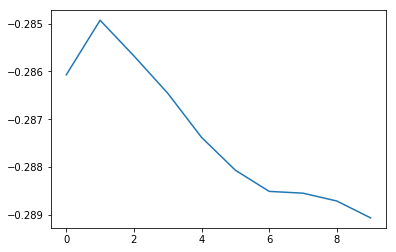

In [243]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
## Sc